In [4]:
import numpy as np
from numpy import linalg
import random
import time
import seaborn as seaborn
from tqdm import tqdm
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

# Step 1 : Data pre-processing

In [23]:
#Load the data
#This is the MNIST datatset that can easily be found online
data = '/Users/ilanasebag/Desktop/CSML_UCL/COMP0078 - SUPERVISED LEARNING /CW2/zipcombo.dat.txt'
data = np.genfromtxt(data)

#Define the training and the testing sets 
def sample_split(data, p_train):
    ns, nf = np.shape(data)
    np.random.shuffle(data)
    training_set = data[0:int(ns*p_train)]
    testing_set = data[int(ns*p_train):]
    return training_set, testing_set

#Split the zipcombo data into xs and ys 
def xydata(data):
    n_sample = int(len(data))
    xs, ys = data[:n_sample,1:] , data[:n_sample,0]
    return xs, ys

# Step 2 : Define useful functions functions 

In [25]:
#Define the polynomial kernel 
def polynomial_kernel(a, b, d):
    K = (np.dot(a.transpose(), b)) ** d
    return K

#Define the array sign function
def sign(x):
    arrshape = np.shape(x)[0]
    sgn = np.ones(arrshape)
    sgn[(x <= 0)] = -1
    return sgn

#Define the k-fold split function for cross validation questions 
def k_fold_validation(trainingset,k=5):

    for i in range(k):
        
        train_fold, val_fold = sample_split(trainingset, 0.8)
        
        train_k_folds = np.array_split(train_fold, k)
        train_k_folds  = np.concatenate(train_k_folds,axis = 0)
        val_k_folds = np.array_split(val_fold, k)
        val_k_folds = np.concatenate(val_k_folds,axis = 0)
        
        #print(np.shape(train_k_folds))
        #print(np.shape(val_k_folds))
    return train_k_folds, val_k_folds

# Step 3 : Define the one-vs-all train and test kernel perceptron functions 

In [16]:
def train_one_vs_all(dataset, w, kernel):
    
    #initialization 
    digits = 10 #as dataset contais digits from 0 to 9
    y_hat = np.zeros((digits))
    errors = 0
    nsamples, nfeatures = np.shape(dataset)
    
    for i in range(nsamples):
        
        K = kernel[i].reshape(-1,1)
        
        y_hat = np.argmax(((w @ K).T)[0])
        y_true = int(dataset[i, 0])
        
        #update step
        ytrueupdate = np.ones(digits) * -1
        ytrueupdate[y_true] = 1
        y_err = np.array((((w @ K).T)[0] * ytrueupdate) <= 0)
        w[y_err, i] = w[y_err, i] - sign(np.array(((w @ K).T)[0][y_err]))  
        
        #compute error 
        if y_hat != y_true:
            errors += 1
        error_percentage = (errors / nsamples)*100
               
    return error_percentage, w

In [17]:
def test_one_vs_all(dataset, w, kernel, confusionmat = False, hardestnbs = False):
    
    #initialization
    digits = 10 ##as dataset contais digits from 0 to 9
    y_hat = np.zeros((digits))
    errors = 0
    nsamples, nfeatures = np.shape(dataset)
    confusion_matrix = np.zeros((digits, digits))
    hn = np.zeros(nsamples)

    for i in range(nsamples):

        K = kernel[i].reshape(-1,1)
        
        y_hat = np.argmax(((w @ K).T)[0])
        y_true = int(dataset[i,0])
        
        #no update step in testing 
        
        #compute error
        if y_hat != y_true:
            errors += 1
            
            if confusionmat == True :
                confusion_matrix[y_true, y_hat]+=1
                confusion_matrix[y_hat, y_true]+=1
                
            if hardestnbs == True : 
                hn[i] += 1
            
        error_percentage = (errors / nsamples)*100
    
    if confusionmat == True :
        for k in range(0,10):
            confusion_matrix[k]=confusion_matrix[k]/(len(np.where(y_true==k)) *nfeatures)
        return confusion_matrix 
    
    elif hardestnbs == True :
        return hn
    
    else :
            
        return error_percentage


# Report mean test & train errors as well as standard deviations for the polynomial kernel perceptron

In [18]:
def q1_1(degrees, runs, digits, epochs, p_train):
    traning_err = [] 
    testing_err = [] 

#---#Run for each d 
    for d in tqdm(degrees):
        #print('Find below the testing and training errors for d = ', d)
        training_err_run = [] 
        testing_err_run = [] 

#-------#Run for each run
        for run in runs:
            #print('For run = ',run)

            train_set, test_set = sample_split(data, p_train)
            trainxs_shape, trainys_shape = np.shape(train_set)
            w = np.zeros((digits, trainxs_shape)) 

            # pre compute kernels (less time consumming to do it here) 
            x1 = (train_set[:, 1:]).transpose()
            x2 = (test_set[:,1:]).transpose()
            KTR = polynomial_kernel(x1,x1, d)
            KTE = polynomial_kernel(x2, x1, d)

            training_err_epoch = []
            testing_err_epoch = []

#----------#Run for each epoch
            for epoch in range(epochs):
                trn_err, w = train_one_vs_all(train_set, w, KTR) 
                tst_err = test_one_vs_all(test_set, w, KTE)
                training_err_epoch.append(trn_err)
                testing_err_epoch.append(tst_err)
                #print('For epoch',epoch,' Train Error: ', trn_err,',', 'Test Error:', tst_err)

            training_err_run.append(training_err_epoch)
            testing_err_run.append(testing_err_epoch)

        traning_err.append(training_err_run)
        testing_err.append(testing_err_run)
        
    for d in degrees:
        print('d=', d,'---------', 'train mean = ', np.mean(traning_err[d-1]), '---------','train std = ',  np.std(traning_err[d-1]))
    
    print('------------------------------------------------------------------------------------------------------')
    
    for d in degrees :
        print('d=', d,'---------',  'test mean = ', np.mean(testing_err[d-1]),  '---------','train std = ',  np.std(testing_err[d-1]))
    
    return None

In [20]:
degrees = np.arange(1,8) 
runs = np.arange(1,21) 
digits = 10 
epochs = 30
p_train= 0.8

q1_1(degrees, runs, digits, epochs, p_train)

100%|██████████| 7/7 [31:19<00:00, 268.51s/it]

d= 1 --------- train mean =  6.76427355023752 --------- train std =  1.829242347975818
d= 2 --------- train mean =  0.6859818947745808 --------- train std =  1.7331533285912206
d= 3 --------- train mean =  0.4122748050551223 --------- train std =  1.4225718993185337
d= 4 --------- train mean =  0.3347001882226405 --------- train std =  1.3182529756159274
d= 5 --------- train mean =  0.30897642735502373 --------- train std =  1.272522252310488
d= 6 --------- train mean =  0.29483732186071526 --------- train std =  1.2692173673896772
d= 7 --------- train mean =  0.289145827731469 --------- train std =  1.250848724736198
------------------------------------------------------------------------------------------------------
d= 1 --------- test mean =  9.217114695340502 --------- train std =  1.3720701842185408
d= 2 --------- test mean =  3.4086021505376345 --------- train std =  0.8052858958355598
d= 3 --------- test mean =  2.9197132616487456 --------- train std =  0.5163789966189328
d= 4 

# Cross validation (without libraries)

In [26]:
#The first step is to find d*

def q1_2(degrees, runs, digits, epochs, p_train, k):
    training_err = [] 
    testing_err = [] 

    for d in tqdm(degrees):
        training_err_run = [] 
        testing_err_run = [] 

        for run in runs:
            trainingset = sample_split(data, 0.8)[0]
        
            for iteration in range(k):
                
                train_k_folds, val_k_folds = k_fold_validation(trainingset,k)
                trainxs_shape, trainys_shape = np.shape(train_k_folds)
                w = np.zeros((digits, trainxs_shape)) 

                # pre compute kernels (less time consumming to do it here) 
                x1 = (train_k_folds[:, 1:]).transpose()
                x2 = (val_k_folds[:,1:]).transpose()
                KTR = polynomial_kernel(x1,x1, d)
                KTE = polynomial_kernel(x2, x1, d)

                training_err_epoch = []
                testing_err_epoch = []

            for epoch in range(epochs):
                trn_err, w = train_one_vs_all(train_k_folds, w, KTR) 
                tst_err = test_one_vs_all(val_k_folds, w, KTE)
                training_err_epoch.append(trn_err)
                testing_err_epoch.append(tst_err)
            

            training_err_run.append(training_err_epoch)
            testing_err_run.append(testing_err_epoch)
            #print(len(testing_err_run))
            
        training_err.append(training_err_run)
        testing_err.append(testing_err_run)
        #print(len(testing_err))

    return training_err

In [27]:
degrees = np.arange(1,8) 
runs = np.arange(1,21) 
digits = 10 
epochs = 5
p_train= 0.8
k = 5
training_err = q1_2(degrees, runs, digits, epochs, p_train, k)

100%|██████████| 7/7 [15:54<00:00, 136.36s/it]


In [32]:
#Construct a matrix where the first row corresponds to the 20 training errors for d = 1 for each run
#Second row is the same for d=2 
#and so on 

r1 = training_err[0]
r2 = training_err[1]
r3 = training_err[2]
r4 = training_err[3]
r5 = training_err[4]
r6 = training_err[5]
r7 = training_err[6]
mat = np.array([r1, r2, r3, r4, r5, r6, r7 ])
twentydsars = []

#Then, find the min err in each column of the matrix and get the corresponding d

for i in np.arange(0,20) : 
    column  = mat[:,i]
    results = np.where(column == np.amin(column))[0]
    singleds = int(((results)[0])+1) #+1 bc python starts at 0 but d values start at 1 
    twentydsars.append(singleds)
print(twentydsars)
print('the mean d* is : ', np.mean(twentydsars))
print('the std d* is : ', np.std(twentydsars))

[6, 7, 6, 6, 5, 7, 4, 6, 4, 6, 6, 5, 7, 7, 6, 6, 7, 7, 6, 6]
the mean d* is :  6.0
the std d* is :  0.8944271909999159


In [35]:
#Now, using the optimal d found above, we find the mean and std test error 

def q1_2_2(degrees, runs, digits, epochs, p_train):
    traning_err = [] 
    testing_err = [] 
    
    for d in tqdm(degrees):
        training_err_run = [] 
        testing_err_run = [] 

        for run in runs:

            train_set, test_set = sample_split(data, p_train)
            trainxs_shape, trainys_shape = np.shape(train_set)
            w = np.zeros((digits, trainxs_shape)) 

            # pre compute kernels (less time consumming to do it here) 
            x1 = (train_set[:, 1:]).transpose()
            x2 = (test_set[:,1:]).transpose()
            KTR = polynomial_kernel(x1,x1, d)
            KTE = polynomial_kernel(x2, x1, d)

            training_err_epoch = []
            testing_err_epoch = []

            for epoch in range(epochs):
                trn_err, w = train_one_vs_all(train_set, w, KTR) 
                tst_err = test_one_vs_all(test_set, w, KTE)
                training_err_epoch.append(trn_err)
                testing_err_epoch.append(tst_err)

            training_err_run.append(training_err_epoch)
            testing_err_run.append(testing_err_epoch)

        traning_err.append(training_err_run)
        testing_err.append(testing_err_run)
 
    return testing_err

In [36]:
ds = np.mean(twentydsars)
dsr = ds
degrees = np.arange(dsr,dsr+1) 
runs = np.arange(1,21) 
digits = 10 
epochs = 30
p_train= 0.8

err = q1_2_2(degrees, runs, digits, epochs, p_train) 

100%|██████████| 1/1 [04:36<00:00, 276.92s/it]


In [37]:
print(np.mean(err))
print(np.std(err))

2.8191756272401434
0.5467136306973822


# Confusion matrix for polynomial kernel perceptron 

In [38]:
#For this question, we use the cross validated d found above 
d_star_final = ds

In [2]:
#The confusion errors are found on the test dataset 

def conf_mat_hardest_err(data,degrees,runs,epochs):

    confusionmat = np.zeros((runs,10,10))
    hn = 0
    digits = 10 
    bestd=d_star_final
    
    for run in range(runs):
        
        trainingset, testingset = sample_split(data,0.8)
        trainxs_shape, trainys_shape = np.shape(trainingset)   
        
        w = np.zeros((digits, trainxs_shape)) 
        
        x1 = (trainingset[:, 1:]).transpose()
        x2 = (testingset[:,1:]).transpose()
        KTR = polynomial_kernel(x1,x1, bestd)
        KTE = polynomial_kernel(x2, x1, bestd)
        
        trn_err, w =train_one_vs_all(trainingset, w, KTR)
        confusionmat[run] = test_one_vs_all(testingset, w, KTE, confusionmat = True)
        
        hn += test_one_vs_all(testingset,w,KTE,confusionmat=False,hardestnbs=True) 
    
    return confusionmat, hn

In [ ]:
degrees = np.arange(1,8)
runs = 20
epochs = 1 
confusion_raw,_ = conf_mat_hardest_err(data, degrees,runs,epochs)

In [74]:
#get means and stds 
conf_mat_mean = np.mean(confusion_raw,axis=0)
conf_mat_std = np.std(confusion_raw,axis=0)
#print(conf_mat_mean)
#print(conf_mat_std)
#print(len(conf_mat_mean))
#print(len(conf_mat_std))

#Create the confusion matrix as a dataframe 

#Return element-wise string concatenation for two arrays
elements=np.char.add(np.char.mod('%.3f', conf_mat_mean),"±")
elements=np.char.add(elements,np.char.mod('%.3f', conf_mat_std))

CONFUSION_MATRIX = pd.DataFrame(data=elements)

CONFUSION_MATRIX.columns = ["y_hat : 0","y_hat : 1","y_hat : 2", "y_hat : 3","y_hat : 4","y_hat : 5", "y_hat : 6", "y_hat : 7","y_hat : 8", "y_hat : 9"]
CONFUSION_MATRIX.index = ["y_true : 0","y_true : 1","y_true : 2", "y_true : 3","y_true : 4","y_true : 5", "y_true : 6", "y_true : 7","y_true : 8", "y_true : 9"]

#make it easy to read :
#blue : lowest values 
#red : highest values
#black : other 

def diag_col(val):
    if val == '0.000+-0.000':
        color = 'blue'
    elif val == '0.022+-0.007' :
        color = 'red'
    elif val ==  '0.023+-0.011':
        color = 'red'
    else :
        color = 'black'
    return 'color: %s' % color

CONFUSION_MATRIX.style.applymap(diag_col)


,y_hat : 0,y_hat : 1,y_hat : 2,y_hat : 3,y_hat : 4,y_hat : 5,y_hat : 6,y_hat : 7,y_hat : 8,y_hat : 9
y_true : 0,0.000+-0.000,0.001+-0.002,0.007+-0.006,0.008+-0.004,0.003+-0.003,0.011+-0.006,0.009+-0.007,0.003+-0.003,0.009+-0.006,0.002+-0.003
y_true : 1,0.001+-0.002,0.000+-0.000,0.003+-0.004,0.001+-0.002,0.009+-0.007,0.002+-0.004,0.003+-0.002,0.002+-0.003,0.004+-0.005,0.002+-0.002
y_true : 2,0.007+-0.006,0.003+-0.004,0.000+-0.000,0.010+-0.007,0.007+-0.006,0.006+-0.005,0.006+-0.005,0.011+-0.004,0.010+-0.006,0.001+-0.002
y_true : 3,0.008+-0.004,0.001+-0.002,0.010+-0.007,0.000+-0.000,0.001+-0.001,0.023+-0.011,0.000+-0.000,0.005+-0.005,0.018+-0.007,0.002+-0.003
y_true : 4,0.003+-0.003,0.009+-0.007,0.007+-0.006,0.001+-0.001,0.000+-0.000,0.007+-0.007,0.007+-0.004,0.009+-0.007,0.006+-0.005,0.022+-0.007
y_true : 5,0.011+-0.006,0.002+-0.004,0.006+-0.005,0.023+-0.011,0.007+-0.007,0.000+-0.000,0.010+-0.009,0.001+-0.002,0.014+-0.006,0.007+-0.006
y_true : 6,0.009+-0.007,0.003+-0.002,0.006+-0.005,0.000+-0.000,0.007+-0.004,0.010+-0.009,0.000+-0.000,0.001+-0.002,0.006+-0.005,0.001+-0.001
y_true : 7,0.003+-0.003,0.002+-0.003,0.011+-0.004,0.005+-0.005,0.009+-0.007,0.001+-0.002,0.001+-0.002,0.000+-0.000,0.005+-0.005,0.015+-0.008
y_true : 8,0.009+-0.006,0.004+-0.005,0.010+-0.006,0.018+-0.007,0.006+-0.005,0.014+-0.006,0.006+-0.005,0.005+-0.005,0.000+-0.000,0.004+-0.004
y_true : 9,0.002+-0.003,0.002+-0.002,0.001+-0.002,0.002+-0.003,0.022+-0.007,0.007+-0.006,0.001+-0.001,0.015+-0.008,0.004+-0.004,0.000+-0.000


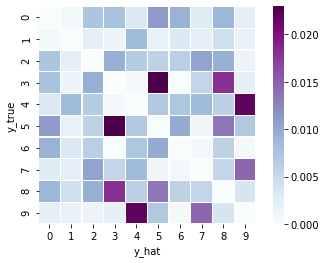

In [77]:
#Plot the mean errors of the confusion matrix in a heatmap
heatmap = seaborn.heatmap(conf_mat_mean, cmap="BuPu")
heatmap.set_xlabel('y_hat')
heatmap.set_ylabel('y_true')
plt.show()

# Hardest nbs to predict

In [48]:
degrees = np.arange(1,8)
runs = 20
epochs = 1 
_,hn = conf_mat_hardest_err(data, degrees,runs,epochs)

In [ ]:
indexes = np.argpartition(hn, -5)[-5:]
HARDEST_NBS = indexes[np.argsort((-hn)[indexes])]
five = len(HARDEST_NBS)

In [49]:
print(HARDEST_NBS)

[ 667 1319  140  561  874]


In [ ]:
#get x data and y data from the xydata() function defined at the beggining of the notebook
xs, ys  = xydata(data)

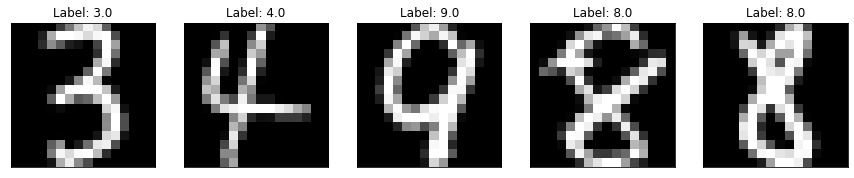

In [75]:
#Plot the five hardest numbers to predict
fig,axs = plt.subplots(1,5,sharey=True,figsize=(15,15))
for i in range(five):
    axs[i].title.set_text(("Label: " + np.str(ys[HARDEST_NBS[i]])))
    axs[i].imshow(np.reshape(xs[HARDEST_NBS[i]],(16,16)),cmap='gray')
    axs[i].set_xticks([])
    axs[i].set_yticks([])